Evaluating RBF function: gaussian_rbf
Accuracy on Training Data: 79.99%
Accuracy on Testing Data: 79.80%
Mean Squared Error on Test Data: 0.1033

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1343
           1       0.74      0.97      0.84      1600
           2       0.57      0.55      0.56      1380
           3       0.84      0.85      0.84      1433
           4       0.92      0.56      0.70      1295
           5       0.77      0.82      0.80      1273
           6       0.95      0.87      0.90      1396
           7       0.92      0.87      0.89      1503
           8       0.90      0.75      0.82      1357
           9       0.58      0.75      0.66      1420

    accuracy                           0.80     14000
   macro avg       0.82      0.79      0.80     14000
weighted avg       0.81      0.80      0.80     14000



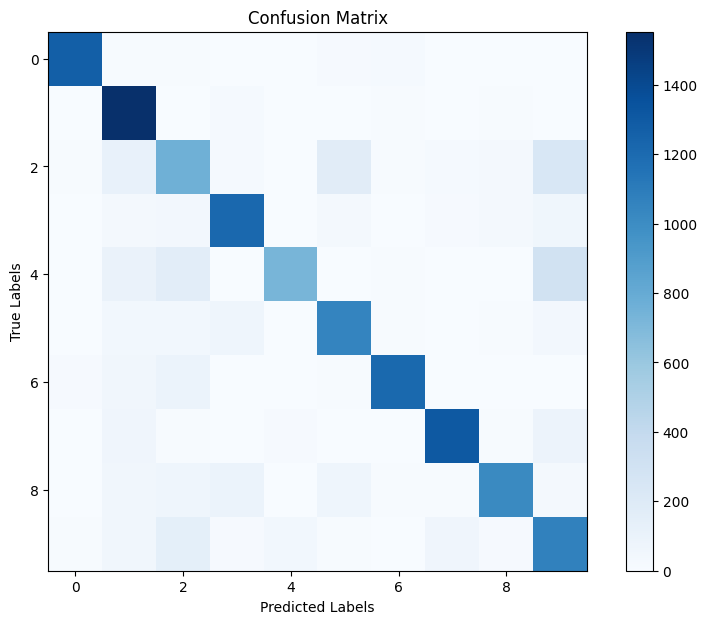

Evaluating RBF function: multiquadric_rbf
Accuracy on Training Data: 90.79%
Accuracy on Testing Data: 90.85%
Mean Squared Error on Test Data: 0.0264

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1343
           1       0.94      0.98      0.96      1600
           2       0.93      0.88      0.90      1380
           3       0.88      0.88      0.88      1433
           4       0.88      0.90      0.89      1295
           5       0.89      0.87      0.88      1273
           6       0.92      0.96      0.94      1396
           7       0.91      0.91      0.91      1503
           8       0.91      0.84      0.88      1357
           9       0.86      0.88      0.87      1420

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000



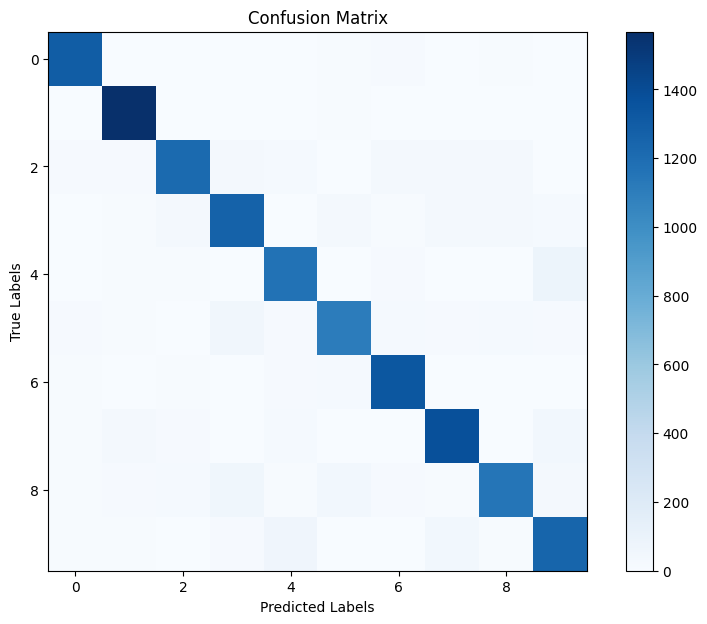

Evaluating RBF function: inverse_multiquadric_rbf
Accuracy on Training Data: 91.28%
Accuracy on Testing Data: 91.13%
Mean Squared Error on Test Data: 0.0232

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1343
           1       0.97      0.97      0.97      1600
           2       0.92      0.90      0.91      1380
           3       0.89      0.89      0.89      1433
           4       0.88      0.89      0.89      1295
           5       0.89      0.90      0.89      1273
           6       0.92      0.96      0.94      1396
           7       0.91      0.92      0.91      1503
           8       0.91      0.86      0.88      1357
           9       0.87      0.86      0.86      1420

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000



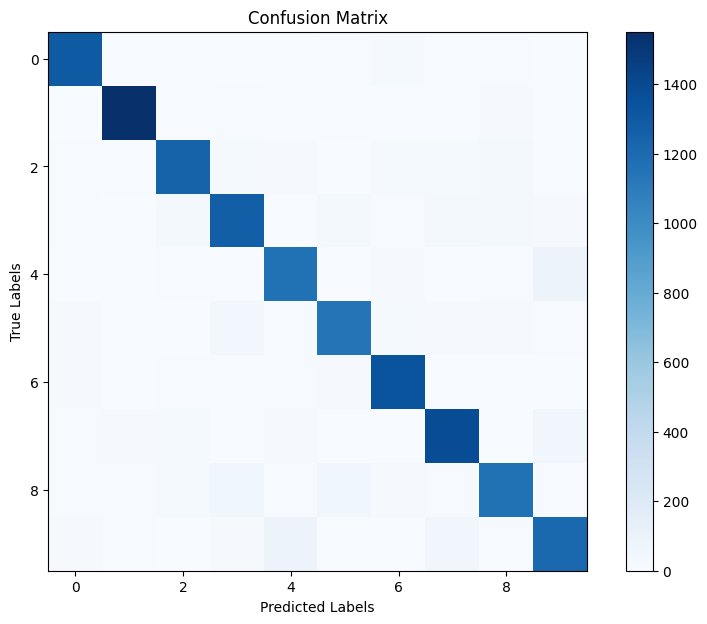

Evaluating RBF function: thin_plate_spline_rbf
Accuracy on Training Data: 87.12%
Accuracy on Testing Data: 87.06%
Mean Squared Error on Test Data: 0.0375

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1343
           1       0.84      0.98      0.90      1600
           2       0.92      0.82      0.87      1380
           3       0.86      0.86      0.86      1433
           4       0.83      0.87      0.85      1295
           5       0.87      0.76      0.81      1273
           6       0.88      0.93      0.90      1396
           7       0.88      0.89      0.88      1503
           8       0.89      0.81      0.85      1357
           9       0.83      0.81      0.82      1420

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



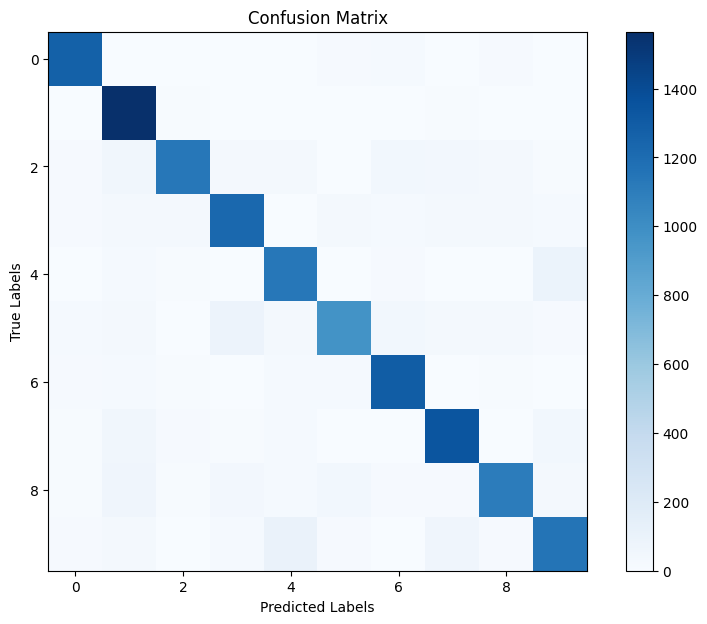

In [4]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
# Load MNIST dataset and ensure it's numerical
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist['data'] / 255.0, mnist['target'].astype(int)

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float64), y, test_size=0.2, random_state=42)
# Define RBF functions
def gaussian_rbf(x, c, sigma):
    return np.exp(-np.linalg.norm(x - c) ** 2 / (2 * sigma ** 2))

def multiquadric_rbf(x, c):
    return np.sqrt(1 + np.linalg.norm(x - c) ** 2)

def inverse_multiquadric_rbf(x, c):
    return 1 / np.sqrt(1 + np.linalg.norm(x - c) ** 2)

def thin_plate_spline_rbf(x, c):
    r = np.linalg.norm(x - c)
    return r ** 2 * np.log(r) if r > 0 else 0

# RBF Network function
def rbf_network(X_train, y_train, X_test, y_test, rbf_function, n_clusters=100):
    # Step 1: Select RBF centers using K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    centers = kmeans.cluster_centers_
    
    # Step 2: Compute RBF activations
    def compute_rbf_activations(X, centers, rbf_func, sigma=1.0):
        activations = np.zeros((X.shape[0], centers.shape[0]))
        for i, x in enumerate(X):
            for j, c in enumerate(centers):
                activations[i, j] = rbf_func(x, c, sigma) if rbf_func == gaussian_rbf else rbf_func(x, c)
        return activations
    
    sigma = np.mean([np.linalg.norm(c1 - c2) for c1 in centers for c2 in centers]) / np.sqrt(2 * n_clusters)
    
    R_train = compute_rbf_activations(X_train, centers, rbf_function, sigma)
    R_test = compute_rbf_activations(X_test, centers, rbf_function, sigma)
    
    # Step 3: Train output weights using least squares method
    weights = np.linalg.pinv(R_train).dot(np.eye(10)[y_train])
    
    # Step 4: Make predictions
    y_pred_train = R_train.dot(weights)
    y_pred_test = R_test.dot(weights)
    
    y_pred_train_labels = np.argmax(y_pred_train, axis=1)
    y_pred_test_labels = np.argmax(y_pred_test, axis=1)
    
    # Step 5: Evaluate performance
    acc_train = accuracy_score(y_train, y_pred_train_labels)
    acc_test = accuracy_score(y_test, y_pred_test_labels)
    mse_test = mean_squared_error(np.eye(10)[y_test], y_pred_test)
    
    print(f"Accuracy on Training Data: {acc_train * 100:.2f}%")
    print(f"Accuracy on Testing Data: {acc_test * 100:.2f}%")
    print(f"Mean Squared Error on Test Data: {mse_test:.4f}")
    
    print("\nClassification Report on Test Data:")
    print(classification_report(y_test, y_pred_test_labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test_labels)
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Evaluate different RBF functions
for rbf_func in [gaussian_rbf, multiquadric_rbf, inverse_multiquadric_rbf, thin_plate_spline_rbf]:
    print(f"Evaluating RBF function: {rbf_func.__name__}")
    rbf_network(X_train, y_train, X_test, y_test, rbf_func)
